In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os

In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

## **Define Functions for Simulations**

In [4]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        Pss = Pss.squeeze()
        return Pss

In [5]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [207]:
#No. of cells per k cell 'type'
n_cells = 500
clus = 3

In [208]:
n_genes = 100
num_marks = 5

In [209]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,TNMD,14950,48,23,10,5,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,DPM1,23689,98,38,25,17,10,6,5,5,...,0,0,0,0,0,0,0,0,0,0
2,SCYL3,44637,132,51,20,13,9,7,6,4,...,0,0,0,0,0,0,0,0,0,0
3,TSPAN6,12884,43,18,13,8,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
4,FGR,23122,41,18,8,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [210]:
#Select gene lengths from human transcriptome
gene_names = np.array(transcriptome[0])
gene_lens = np.array(transcriptome[1])

choices = random.sample(range(len(gene_names)), n_genes)
names_sub = gene_names[choices]
lens_sub = gene_lens[choices]

In [211]:
#For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m
for g in range(n_genes):
    g_len = lens_sub[g]
    params[:,g,0] = int(np.random.uniform(8,12)) #b
    params[:,g,1] = 1 #np.random.uniform(0.1,0.5) #k
    params[:,g,2] = np.random.normal(2,0.1)  #beta
    params[:,g,3] = np.random.normal(0.8,0.1) #gamma
    
    params[:,g,4] = 10**(-7.157894736842105)*g_len #C_nL
    params[:,g,5] = 10**(-1.525) #lam_m
    


#For each clus, select num_marks unique markers, add noise to b (log10b)
all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
for c in range(clus):
    marks = all_choices[c*num_marks:(c+1)*num_marks]
    
    params[c,marks,0] = 10**(np.log10(params[c,marks,0]) + np.random.normal(loc=1.0, scale = 0.1, size=len(marks))) #Only in burst size for now



In [308]:
#For each clus get n_cells samples + concat, 
all_counts = np.zeros((clus*n_cells,n_genes,2))
for c in range(clus):
    
    for g in range(n_genes):
        
        b = params[c,g,0]
        k = params[c,g,1]
        beta = params[c,g,2]
        gamma = params[c,g,3]
        
        samp = [params[c,g,4], params[c,g,5]]

        p = np.log10(np.asarray([b,beta/k,gamma/k]))
        burst_model = BurstModel('Poisson')

        max_mean = b*k*np.asarray([1/beta,1/gamma]) #np.array(samp)*
        max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))
        
        #max_std = np.sqrt(max_mean*(1+np.array(samp)+(np.array(samp)*b)*np.asarray([1,beta/(beta+gamma)])))
        
        max_domain = max_mean + 4*max_std
        print(max_mean)
        max_domain = [int(i) for i in max_domain]
        print(max_domain)

        Pss = burst_model.get_Pss(p,max_domain,samp)

        #Get N and M count samples
        sampled = sample_from_p(n_cells, Pss)
        all_counts[c*n_cells:(c+1)*n_cells,g,0] = sampled[0]
        all_counts[c*n_cells:(c+1)*n_cells,g,1] = sampled[1]





[ 4.92490843 13.35035579]
[34, 55]
[3.90303004 9.62653054]
[27, 41]
[ 5.27177405 12.84153095]
[35, 53]
[ 3.89483037 10.20852006]
[27, 43]
[ 5.28271396 12.7098817 ]
[37, 54]
[ 4.71607588 11.70260295]
[33, 50]
[ 5.1466726  14.24532269]
[35, 57]
[ 5.12097205 14.9898241 ]
[35, 60]
[ 4.05143737 11.00296244]
[28, 45]
[ 5.79333638 12.37206569]
[39, 53]
[ 5.322342   12.86202382]
[35, 53]
[3.90997718 9.23831393]
[27, 40]
[ 4.02873134 10.42297949]
[28, 44]
[ 5.87259269 15.7718007 ]
[39, 63]
[ 4.24307999 10.23827929]
[30, 44]
[ 5.66179698 15.40063015]
[38, 62]
[4.13493983 9.43428358]
[28, 40]
[ 4.96969791 11.13668287]
[33, 47]
[ 4.26952053 10.59176472]
[29, 44]
[ 4.74752087 15.00342627]
[33, 60]
[ 5.48899825 13.05704923]
[37, 55]
[ 5.68800021 15.70937729]
[38, 63]
[ 5.75523896 16.82026717]
[38, 66]
[ 5.01528737 13.73932827]
[34, 56]
[3.75687729 9.87433197]
[27, 42]
[ 4.44369239 11.5829337 ]
[31, 48]
[ 4.85195183 12.12222179]
[34, 51]
[ 4.91881012 14.50558348]
[34, 58]
[3.88280805 9.47161141]
[27,

[ 4.75168564 11.84849239]
[32, 49]
[ 49.10585537 128.28316917]
[343, 534]
[ 5.42942724 13.26684877]
[37, 56]
[ 5.69283635 15.00582692]
[38, 61]
[3.66736875 8.57785136]
[26, 38]
[ 4.28309435 11.99269227]
[30, 50]
[ 5.79060548 14.32417991]
[39, 59]
[ 5.46999499 13.32439574]
[37, 56]
[ 4.77935759 14.4287461 ]
[33, 58]
[3.63085503 9.07859916]
[26, 40]
[ 5.1276415  15.72185304]
[35, 62]
[ 4.60384044 10.59214572]
[31, 45]
[4.96385496 9.61855242]
[34, 43]
[4.11963468 9.82985978]
[28, 42]
[ 5.01885358 12.62284786]
[34, 53]
[ 5.22507442 14.0954683 ]
[36, 59]
[3.73992424 8.45912384]
[26, 38]
[4.38500952 9.24973044]
[30, 41]
[ 77.32663108 250.97875558]
[515, 941]
[4.01387328 8.67298585]
[28, 38]
[ 4.1423615  13.30436447]
[29, 54]
[ 4.2034003  10.32212427]
[30, 45]
[ 5.52241242 14.71205616]
[38, 60]
[ 5.03144211 14.86456551]
[34, 59]
[ 5.76021136 14.71807073]
[39, 60]
[ 5.29382314 15.13329208]
[35, 60]
[ 4.60468358 12.21880877]
[33, 52]
[3.88848887 9.34374735]
[27, 40]
[ 4.78793346 14.36730114]
[3

In [213]:

concat_types = np.concatenate((np.mean(all_counts[0:500,:,:],axis=0),np.mean(all_counts[500:1000,:,:],axis=0),
          np.mean(all_counts[1000:1500,:,:],axis=0)),axis=1)


In [214]:
#Which genes chosen as markers
all_choices

array([69, 79, 99, 75, 80, 95, 45, 23,  0, 15, 48, 46, 84, 65, 17])

[Text(1, 0.5, '65'),
 Text(1, 1.5, '84'),
 Text(1, 2.5, '17'),
 Text(1, 3.5, '46'),
 Text(1, 4.5, '48'),
 Text(1, 5.5, '45'),
 Text(1, 6.5, '23'),
 Text(1, 7.5, '15'),
 Text(1, 8.5, '0'),
 Text(1, 9.5, '95'),
 Text(1, 10.5, '63'),
 Text(1, 11.5, '91'),
 Text(1, 12.5, '51'),
 Text(1, 13.5, '56'),
 Text(1, 14.5, '11'),
 Text(1, 15.5, '3'),
 Text(1, 16.5, '24'),
 Text(1, 17.5, '66'),
 Text(1, 18.5, '1'),
 Text(1, 19.5, '64'),
 Text(1, 20.5, '74'),
 Text(1, 21.5, '59'),
 Text(1, 22.5, '94'),
 Text(1, 23.5, '86'),
 Text(1, 24.5, '58'),
 Text(1, 25.5, '81'),
 Text(1, 26.5, '96'),
 Text(1, 27.5, '98'),
 Text(1, 28.5, '29'),
 Text(1, 29.5, '30'),
 Text(1, 30.5, '38'),
 Text(1, 31.5, '25'),
 Text(1, 32.5, '42'),
 Text(1, 33.5, '87'),
 Text(1, 34.5, '5'),
 Text(1, 35.5, '26'),
 Text(1, 36.5, '52'),
 Text(1, 37.5, '73'),
 Text(1, 38.5, '44'),
 Text(1, 39.5, '47'),
 Text(1, 40.5, '82'),
 Text(1, 41.5, '88'),
 Text(1, 42.5, '14'),
 Text(1, 43.5, '60'),
 Text(1, 44.5, '85'),
 Text(1, 45.5, '16'),
 T

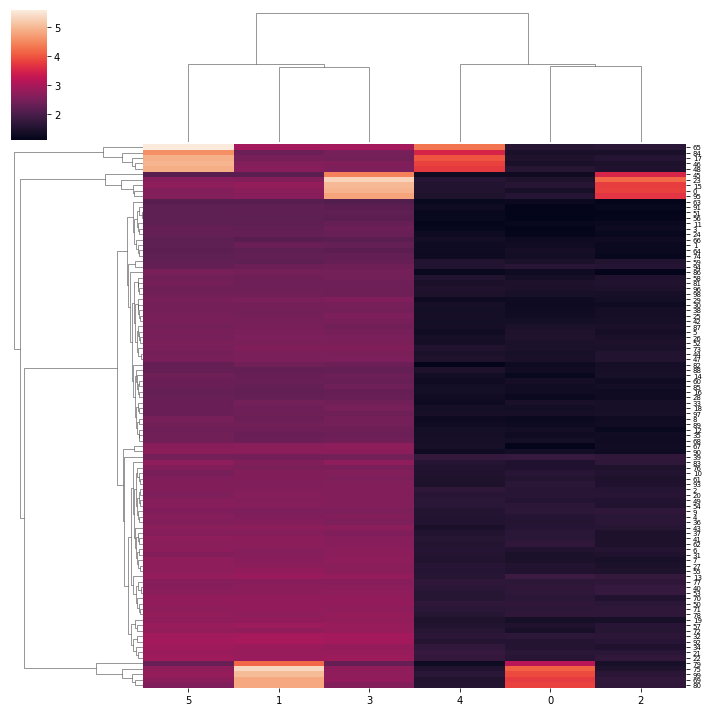

In [215]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log(concat_types),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)


Text(0, 0.5, 'Mature counts')

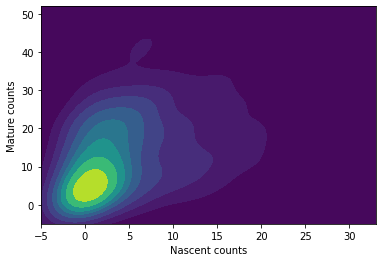

In [270]:
plt.figure()
test = all_counts[0:500,10]
sns.kdeplot(x=test[:,0], y=test[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlim(np.min(test[:,0])-5,np.max(test[:,0])+1)
plt.ylim(np.min(test[:,1])-5,np.max(test[:,1])+1)
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [217]:
np.max(all_counts[:,10,1])

52.0

In [289]:
# !mkdir ~/counts/mixMod_sims
# !mkdir ~/counts/mixMod_sims/loom/

**Save count matrices for Monod**

In [218]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[:,:,0]
S = all_counts[:,:,1]
geneNames = names_sub
bars = [str(i) for i in range(n_cells*clus)]

fname = out_path+'burst_mark_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)


Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [219]:
#Make loom with just one cluster, for comparing to Monod fits
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[0:n_cells,:,0]
S = all_counts[0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_burst_mark_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)

Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [220]:
#Check loom ok
import loompy as lp
ds = lp.connect('/home/tchari/counts/mixMod_sims/loom/burst_mark_sim.loom')

In [221]:
ds

,,barcode,0,1,2,3,4,5,6,7,8,9,...
,,obs_names,0,1,2,3,4,5,6,7,8,9,...
gene_name,var_names,,,,,,,,,,,,...
AC099563.1,AC099563.1,,13.0,10.0,22.0,6.0,10.0,13.0,29.0,4.0,5.0,7.0,...
AL512622.1,AL512622.1,,1.0,11.0,24.0,12.0,0.0,0.0,13.0,2.0,10.0,11.0,...
PTGS2,PTGS2,,2.0,13.0,4.0,4.0,20.0,20.0,12.0,42.0,10.0,28.0,...
USP17L11,USP17L11,,6.0,3.0,20.0,9.0,0.0,8.0,5.0,4.0,5.0,13.0,...
B4GALNT2,B4GALNT2,,3.0,0.0,26.0,6.0,10.0,7.0,8.0,10.0,0.0,5.0,...
RBMS1P1,RBMS1P1,,31.0,18.0,18.0,16.0,5.0,0.0,11.0,7.0,6.0,17.0,...
KIR2DL4,KIR2DL4,,14.0,12.0,22.0,3.0,0.0,24.0,5.0,51.0,55.0,7.0,...
LINC01908,LINC01908,,9.0,8.0,2.0,7.0,11.0,31.0,40.0,13.0,18.0,9.0,...


In [222]:
ds.close()

In [223]:
#All params from sim, for comparison to fits (for each gene)
params.shape

(3, 100, 6)

## **Run Inference**

In [266]:
#Save cell cluster assigns and marker genes
true_clus = []
true_marks = []
for i in range(clus):
    true_clus += [list(np.array(bars)[i*n_cells:(i+1)*n_cells])]
    true_marks += [list(all_choices[i*num_marks:(i+1)*num_marks])]
    


In [267]:
true = pd.DataFrame()
true['clus'] = range(clus)
true['cells'] = true_clus
true['marks'] = true_marks
true.head()

,clus,cells,marks
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[69, 79, 99, 75, 80]"
1,1,"[500, 501, 502, 503, 504, 505, 506, 507, 508, ...","[95, 45, 23, 0, 15]"
2,2,"[1000, 1001, 1002, 1003, 1004, 1005, 1006, 100...","[48, 46, 84, 65, 17]"


In [226]:
dataset_meta = ['burst_mark_sim','oneClus_burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()



cluster_names = []
dataset_names = ['burst_mark_sim','oneClus_burst_mark_sim']   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = ['burst_mark_sim','oneClus_burst_mark_sim']
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/mixMod_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['burst_mark_sim', 'oneClus_burst_mark_sim']

dataset_names:  ['burst_mark_sim', 'oneClus_burst_mark_sim']
len(dataset_names):  2

loom_filepaths:  ['/home/tchari/counts/mixMod_sims/loom/burst_mark_sim.loom', '/home/tchari/counts/mixMod_sims/loom/oneClus_burst_mark_sim.loom']


Dataset burst_mark_sim. 
	1500 barcodes in loom, 1500 pass filter. 1500 in annotations; of these, 1500 in loom and 1500 in filtered loom.
	All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset oneClus_burst_mark_sim. 
	500 barcodes in loom, 500 pass filter. 500 in annotations; of these, 500 in loom and 500 in filtered loom.
	All: 500 cells in annotations. 500 in loom. 500 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


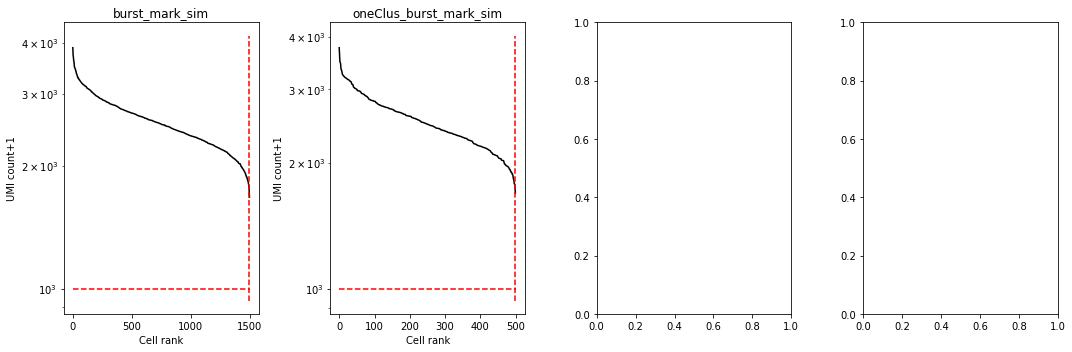

In [227]:
#Not filtering cells for now
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        #for subcluster in subcluster_names:
        subcluster = 'All'
        annot_bcs = bcs
        #cf.append(np.isin(bcs,annot_bcs) & cf_)
        cf.append(np.isin(bcs,annot_bcs))
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [228]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [229]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


(array([72., 23.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  1.]),
 array([0.90308999, 1.03137619, 1.15966239, 1.28794859, 1.41623479,
        1.54452099, 1.67280719, 1.80109339, 1.92937959, 2.05766579,
        2.18595199]),
 <BarContainer object of 10 artists>)

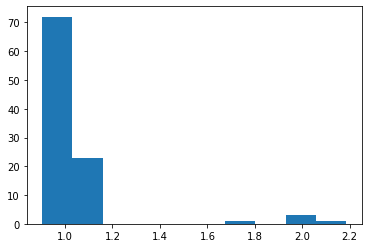

In [230]:
plt.hist(np.log10(params[0,:,0]))

In [231]:
k=3
epochs=10

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1 created.
INFO:root:Dataset: burst_mark_sim
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:89 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/burst_mark_sim created.
INFO:root:Dataset: oneClus_burst_mark_sim
INFO:root:500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:96 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/oneClus_burst_mark_sim created.
INFO:root:Total of 100 genes selected.
INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/diagnostic_figures created.


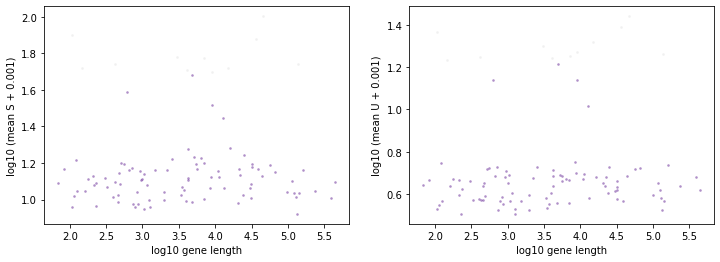

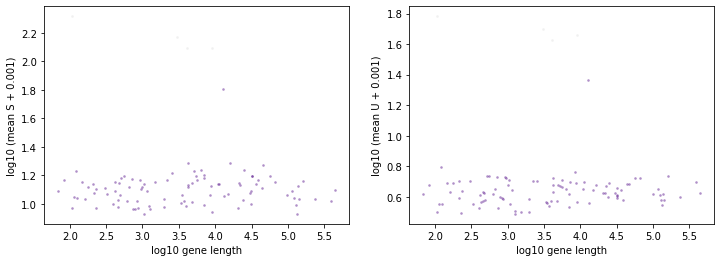

In [232]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='burst_mark_sim_MM_k3',batch_id=1,\
                                             n_genes=100,exp_filter_threshold=None,cf=cf)

**Control test with standard Monod fit on first, known cluster of cells**

INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/oneClus_burst_mark_sim/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/oneClus_burst_mark_sim/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_burst_mark_sim
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/genes.csv.
INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/oneClus_burst_mark_sim/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/oneClus_burst_mark_sim/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:40<00:00, 220.16s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/oneClus_burst_mark_sim/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 220.5 seconds.


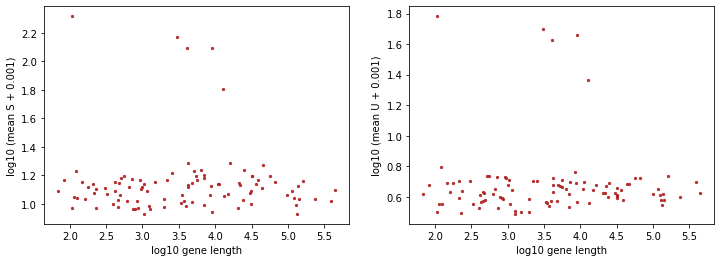

In [233]:
#Control test with standard Monod fit on first, known cluster of cells
result_strings = []
for i in range(1,2): #n_datasets
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [234]:
sr = monod.analysis.load_search_results(result_strings[0])

INFO:root:Grid scan results loaded from ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/oneClus_burst_mark_sim/Bursty_Poisson_1x1/grid_scan_results.res.


**Run Mixture Model on all cells**

INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/burst_mark_sim/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/burst_mark_sim/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: burst_mark_sim
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/genes.csv.
INFO:root:Directory ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/burst_mark_sim/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230331_025_burst_mark_sim_MM_k3_1/burst_mark_sim/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:54<00:00, 178.05s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [09:17<00:00, 185.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33943611 0.24081524 0.41974866]
logL:  -734.1213206341732

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:05<00:00, 141.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.26821123 0.41087726 0.32091151]
logL:  -731.5603965182426

INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:10<00:00, 143.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36434571 0.21212356 0.42353073]
logL:  -728.8793084687364

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:03<00:00, 141.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.38232318 0.14249594 0.47518088]
logL:  -727.255108584087

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:26<00:00, 148.84s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.38349375 0.27773277 0.33877348]
logL:  -726.282070901346

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:57<00:00, 99.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.58768588 0.30358445 0.10872967]
logL:  -734.8443694987276

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:57<00:00, 119.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.52506565 0.35905556 0.11587879]
logL:  -728.2957389142787

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:20<00:00, 146.89s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4153024  0.31938471 0.2653129 ]
logL:  -724.409905970844

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:16<00:00, 125.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3581533  0.3360731  0.30577359]
logL:  -720.4694114875151

INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:52<00:00, 97.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35757176 0.30886096 0.33356728]
logL:  -733.9190789872439

INFO:root:Non-parallelized grid scan complete.


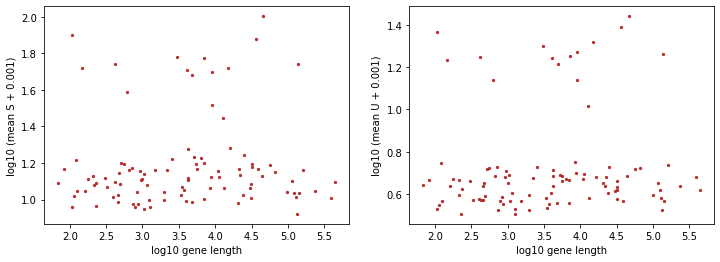

In [235]:

result_strings = []
for i in range(0,1): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=k,epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


## **Analysis of Results**

In [236]:
#Mixture Model results
import pickle 
with open("/home/tchari/perturbCME/notebooks/fits/gg_230331_025_burst_mark_sim_MM_k3_1/burst_mark_sim/Bursty_Poisson_1x1/grid_point_0.gp", "rb") as ipfs:
    grid_point_results_k3 = pickle.load(ipfs)
    

In [243]:
cell_res = pd.DataFrame()
assigns = grid_point_results_k3.assigns
cluster = []
assign = []
for i in range(clus):
    cluster += [i]*n_cells
    assign += list(grid_point_results_k3.assigns[i*n_cells:(i+1)*n_cells])
    
cell_res['orig_cluster'] = cluster
cell_res['assign'] = assign
cell_res.head()

,orig_cluster,assign
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


Text(0.5, 0, 'MM Assignment')

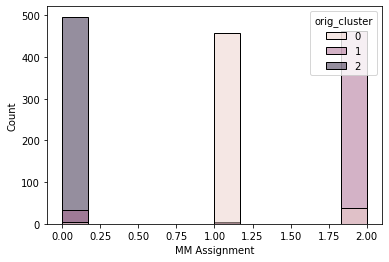

In [262]:
sns.histplot(data=cell_res, x="assign",hue='orig_cluster', kde=False)
plt.xlabel('MM Assignment')

Text(0, 0.5, 'NLL')

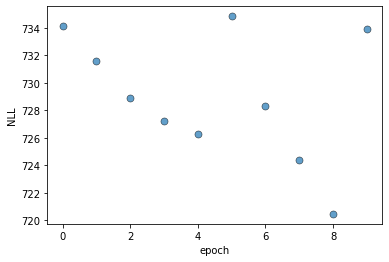

In [245]:
sns.scatterplot(x=range(len(grid_point_results_k3.all_bounds)),y=-1*np.array(grid_point_results_k3.all_bounds),
            alpha=0.7,s=50,edgecolor='black')
plt.xlabel('epoch')
plt.ylabel('NLL')

In [246]:
grid_point_results_k3.aic #Compare with k = 2

-734.5204123205772

In [375]:
#Compare parameter fits, gene x param x k to simulated params
grid_point_results_k3.param_estimates.shape

(100, 3, 3)

In [309]:
pred_b0 = grid_point_results_k3.param_estimates[:,0,0]
pred_b1 = grid_point_results_k3.param_estimates[:,0,1]

In [310]:
pred_b0.shape

(100,)

In [297]:
#pred_b0 = np.log10((lens_sub*10**(-7.157894736842105))*(10**(pred_b0) + 1)) #/ samp[0] - 1

In [311]:
true_b0 = params[0,:,0]
true_b1 = params[1,:,0]

(array([72., 23.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  1.]),
 array([0.90308999, 1.03137619, 1.15966239, 1.28794859, 1.41623479,
        1.54452099, 1.67280719, 1.80109339, 1.92937959, 2.05766579,
        2.18595199]),
 <BarContainer object of 10 artists>)

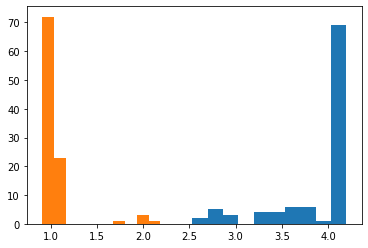

In [312]:
plt.hist(pred_b0)
plt.hist(np.log10(true_b0))

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

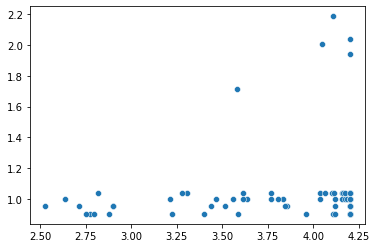

In [313]:
sns.scatterplot(pred_b0,np.log10(true_b0))

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

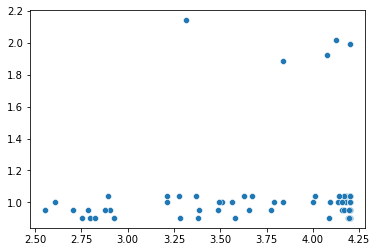

In [253]:
sns.scatterplot(pred_b1,np.log10(true_b1))


**Compare params to control Monod, single-cluster test**

In [254]:
sr.param_estimates[0].shape

(100, 3)

In [255]:
true_b0 = params[0,:,0]

(array([72., 23.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  1.]),
 array([0.90308999, 1.03137619, 1.15966239, 1.28794859, 1.41623479,
        1.54452099, 1.67280719, 1.80109339, 1.92937959, 2.05766579,
        2.18595199]),
 <BarContainer object of 10 artists>)

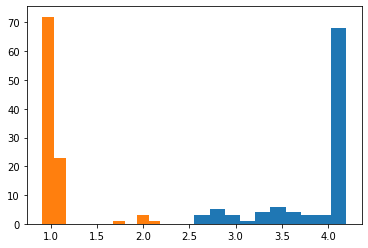

In [256]:
plt.hist(sr.param_estimates[0][:,0]) #Monod also not getting params right without EM
plt.hist(np.log10(true_b0))

array([[1.        , 0.94245049],
       [0.94245049, 1.        ]])

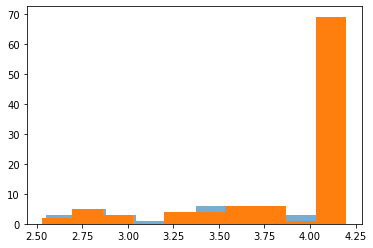

In [257]:
pred_b0 = grid_point_results_k3.param_estimates[:,0,0]
plt.hist(sr.param_estimates[0][:,0],alpha=0.6)
plt.hist(pred_b0)
np.corrcoef(sr.param_estimates[0][:,0],pred_b0)

array([[1.        , 0.87494348],
       [0.87494348, 1.        ]])

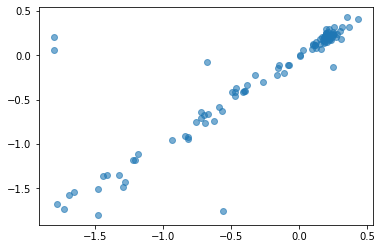

In [258]:
pred_b0 = grid_point_results_k3.param_estimates[:,1,0]
plt.scatter(sr.param_estimates[0][:,1],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,1],pred_b0)

array([[1.        , 0.49130319],
       [0.49130319, 1.        ]])

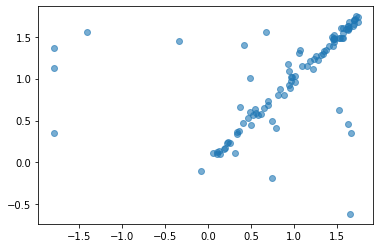

In [259]:
pred_b0 = grid_point_results_k3.param_estimates[:,2,0]
plt.scatter(sr.param_estimates[0][:,2],pred_b0,alpha=0.6)
np.corrcoef(sr.param_estimates[0][:,2],pred_b0)

## **MISC**

In [85]:
#Init values per gene

np.random.seed(42)

b=10 #10
k = 0.2 #0.2 
beta = 1 #1
gamma = 0.8 #0.8
samp = [0.008,10**(-1.525)] #[0.4,0.5], from data 10**(-7.157894736842105)*len + 10**(-1.525) 




In [86]:
#Get PSS for gene
p = np.log10(np.asarray([b,beta/k,gamma/k]))
burst_model = BurstModel('Poisson')

max_mean = b*k*np.asarray([1/beta,1/gamma])
max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))
max_domain = max_mean + 4*max_std
max_domain = [int(i) for i in max_domain]

Pss = burst_model.get_Pss(p,max_domain,samp)

#Get samples
test = sample_from_p(100, Pss)


[20, 18]


In [281]:
all_counts.shape

(1500, 100, 2)

In [187]:
all_choices

array([16, 94, 30, 72, 63, 66, 62, 92, 26, 38, 73, 82, 40, 87, 42,  0,  5,
        3, 59, 24, 61, 99, 44, 45, 88, 93, 13, 20, 37, 34])

Text(0, 0.5, 'Mature counts')

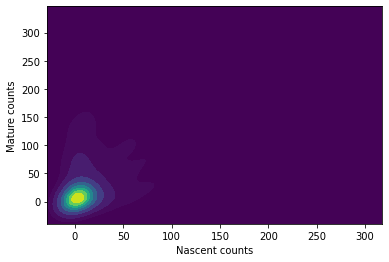

In [305]:
plt.figure()
test = all_counts[:,0]
sns.kdeplot(x=test[:,0], y=test[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [331]:

concat_types = np.concatenate((np.mean(all_counts[0:500,:,:],axis=0),np.mean(all_counts[500:1000,:,:],axis=0),
          np.mean(all_counts[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '74'),
 Text(1, 1.5, '15'),
 Text(1, 2.5, '48'),
 Text(1, 3.5, '11'),
 Text(1, 4.5, '33'),
 Text(1, 5.5, '94'),
 Text(1, 6.5, '40'),
 Text(1, 7.5, '86'),
 Text(1, 8.5, '19'),
 Text(1, 9.5, '73'),
 Text(1, 10.5, '27'),
 Text(1, 11.5, '96'),
 Text(1, 12.5, '17'),
 Text(1, 13.5, '69'),
 Text(1, 14.5, '45'),
 Text(1, 15.5, '65'),
 Text(1, 16.5, '36'),
 Text(1, 17.5, '88'),
 Text(1, 18.5, '0'),
 Text(1, 19.5, '4'),
 Text(1, 20.5, '12'),
 Text(1, 21.5, '13'),
 Text(1, 22.5, '39'),
 Text(1, 23.5, '67'),
 Text(1, 24.5, '82'),
 Text(1, 25.5, '58'),
 Text(1, 26.5, '81'),
 Text(1, 27.5, '85'),
 Text(1, 28.5, '53'),
 Text(1, 29.5, '60'),
 Text(1, 30.5, '42'),
 Text(1, 31.5, '46'),
 Text(1, 32.5, '24'),
 Text(1, 33.5, '43'),
 Text(1, 34.5, '7'),
 Text(1, 35.5, '41'),
 Text(1, 36.5, '10'),
 Text(1, 37.5, '57'),
 Text(1, 38.5, '83'),
 Text(1, 39.5, '5'),
 Text(1, 40.5, '50'),
 Text(1, 41.5, '80'),
 Text(1, 42.5, '25'),
 Text(1, 43.5, '54'),
 Text(1, 44.5, '37'),
 Text(1, 45.5, '56'),
 T

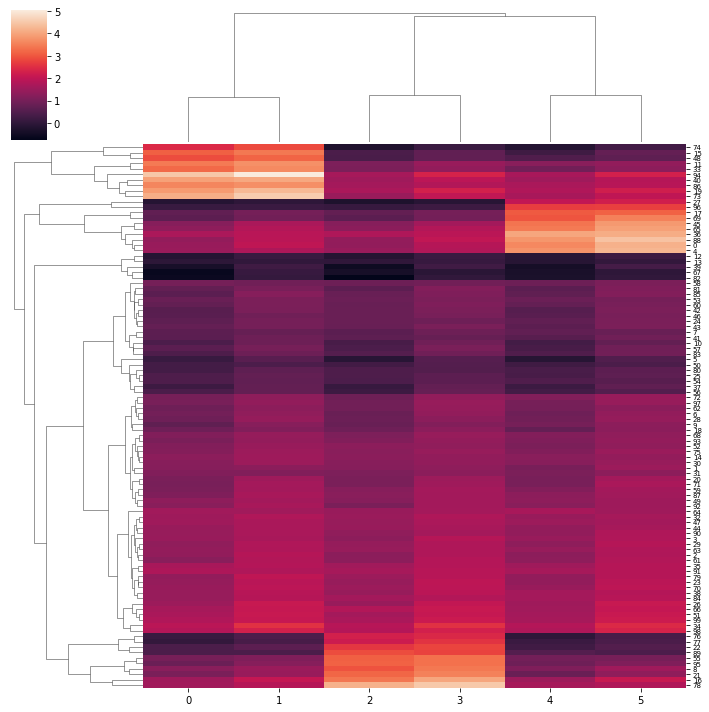

In [343]:
#Make heatmap with markers

g = sns.clustermap(np.log(concat_types),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)


[Text(1, 0.5, '94'),
 Text(1, 1.5, '78'),
 Text(1, 2.5, '73'),
 Text(1, 3.5, '19'),
 Text(1, 4.5, '40'),
 Text(1, 5.5, '45'),
 Text(1, 6.5, '65'),
 Text(1, 7.5, '36'),
 Text(1, 8.5, '88'),
 Text(1, 9.5, '0'),
 Text(1, 10.5, '4'),
 Text(1, 11.5, '11'),
 Text(1, 12.5, '86'),
 Text(1, 13.5, '15'),
 Text(1, 14.5, '33'),
 Text(1, 15.5, '69'),
 Text(1, 16.5, '17'),
 Text(1, 17.5, '96'),
 Text(1, 18.5, '48'),
 Text(1, 19.5, '74'),
 Text(1, 20.5, '76'),
 Text(1, 21.5, '77'),
 Text(1, 22.5, '22'),
 Text(1, 23.5, '89'),
 Text(1, 24.5, '34'),
 Text(1, 25.5, '98'),
 Text(1, 26.5, '26'),
 Text(1, 27.5, '66'),
 Text(1, 28.5, '51'),
 Text(1, 29.5, '99'),
 Text(1, 30.5, '27'),
 Text(1, 31.5, '7'),
 Text(1, 32.5, '41'),
 Text(1, 33.5, '57'),
 Text(1, 34.5, '10'),
 Text(1, 35.5, '83'),
 Text(1, 36.5, '58'),
 Text(1, 37.5, '53'),
 Text(1, 38.5, '60'),
 Text(1, 39.5, '24'),
 Text(1, 40.5, '42'),
 Text(1, 41.5, '43'),
 Text(1, 42.5, '46'),
 Text(1, 43.5, '81'),
 Text(1, 44.5, '85'),
 Text(1, 45.5, '12'),
 

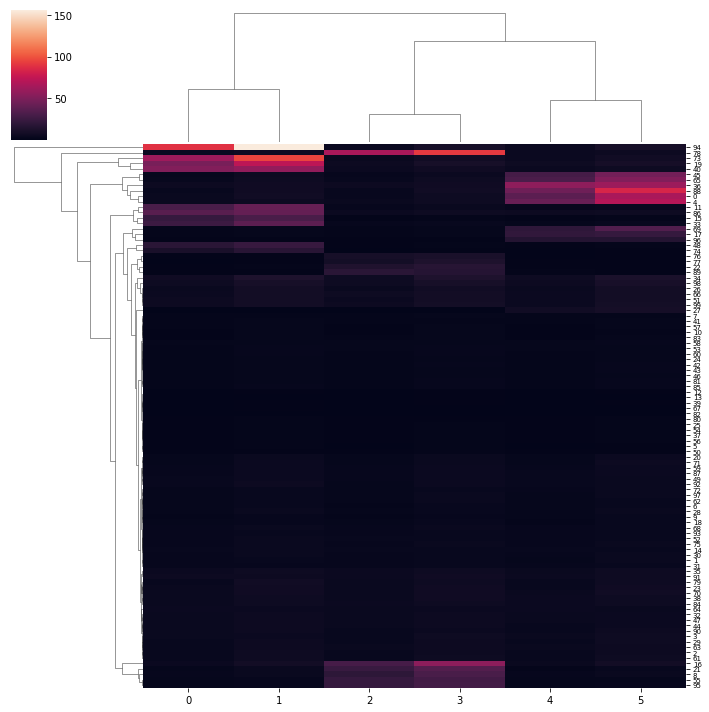

In [344]:
g = sns.clustermap(concat_types,yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)
